In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
meas = Base.classes.measurement
stat = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [28]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [128]:
col = inspector.get_columns('measurement')
for x in col:
    print(f"'{x['name']}',")

'id',
'station',
'date',
'prcp',
'tobs',


# Exploratory Climate Analysis

[('2017-08-23',)]
2016-08-23


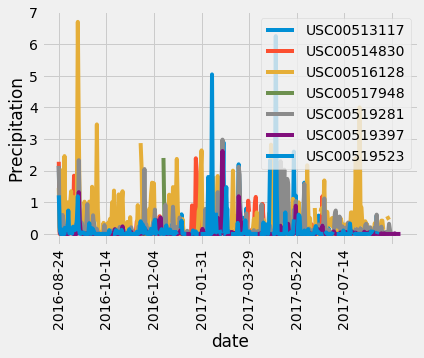

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lst=session.query(meas.date).order_by(meas.date.desc()).limit(1).all()
print(lst)
# Calculate the date 1 year ago from the last data point in the databasete
lst_dt = dt.datetime.strptime(lst[0][0], '%Y-%m-%d')
year_ago = lst_dt - dt.timedelta(days=365)
year_ago_str = year_ago.strftime('%Y-%m-%d')
print(year_ago_str)
# Perform a query to retrieve the data and precipitation scores
precip = session.query(meas.date,meas.prcp,meas.station).filter(meas.date > year_ago_str)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['date', 'prcp','station'])
# Sort the dataframe by date
df.set_index('date',inplace=True)
df.groupby('station')['prcp'].plot(legend=True)
plt.ylabel('Precipitation')
plt.xticks(rotation=90)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.groupby('station').describe()

prcp                                                   
             count      mean       std  min   25%   50%     75%   max
station                                                              
USC00513117  342.0  0.141404  0.341744  0.0  0.00  0.03  0.1175  2.90
USC00514830  264.0  0.125720  0.316856  0.0  0.00  0.02  0.1200  2.39
USC00516128  327.0  0.449878  0.718140  0.0  0.01  0.18  0.6050  6.70
USC00517948   60.0  0.076500  0.317857  0.0  0.00  0.00  0.0250  2.40
USC00519281  351.0  0.194416  0.411050  0.0  0.00  0.06  0.1850  2.98
USC00519397  358.0  0.044944  0.189059  0.0  0.00  0.00  0.0200  2.62
USC00519523  313.0  0.121374  0.509785  0.0  0.00  0.00  0.0600  6.25

In [14]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
stations = session.query(func.count(distinct(meas.station))).all()
print(f"There are {stations[0][0]} stations in this dataset.")

There are 9 stations in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stat = session.query(meas.station,func.count(meas.date)).group_by(meas.station).all()
df2=pd.DataFrame(stat, columns=['Station','Rows'])
df2=df2.sort_values('Rows',ascending =False) 
df2.head(15)

,Station,Rows
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [45]:
stat_id = session.query(stat.station,stat.name,stat.latitude,stat.longitude,stat.elevation).all()
stat_df=pd.DataFrame(stat_id,columns=['Station','name','latitude','longitude','elevation'])
final_df = pd.merge(stat_df,df2,on='Station')

In [44]:
final_df.head(9)

,Station,name,latitude,longitude,elevation,Rows
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2724
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2709
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2202
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,1372
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,511
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2669
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2772
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1979
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2612


In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_t = session.query(func.max(meas.tobs)).filter(meas.station == 'USC00519281').all()
min_t =session.query(func.min(meas.tobs)).filter(meas.station == 'USC00519281').all()
avg_t = session.query(func.avg(meas.tobs)).filter(meas.station == 'USC00519281').all()
print(f'Station USC00519281 had a max temp of {max_t[0][0]} a min temp {min_t[0][0]} and an avg temp of {round(avg_t[0][0],2)}.')

Station USC00519281 had a max temp of 85.0 a min temp 54.0 and an avg temp of 71.66.


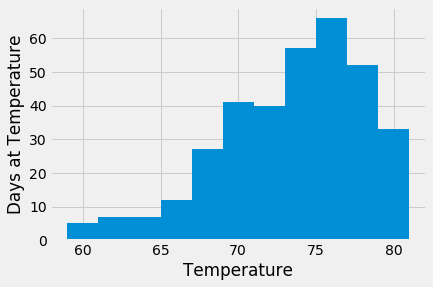

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stat_1 = session.query(meas.tobs).filter(meas.date>year_ago_str).filter(meas.station=='USC00519281')
df3=pd.DataFrame(stat_1, columns=['Temp'])
max1=int(df3.max())
min1 = int(df3.min())
step = int((max1-min1)/12)
bins=np.arange(min1,max1,step)
plt.hist(df3['Temp'],bins=bins)
plt.ylabel("Days at Temperature")
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [81]:
# Challenge I
from scipy import stats
sel = [func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)]
june_avg=session.query(*sel).filter(func.strftime("%m", meas.date) =="06" ).all()
dec_avg=session.query(*sel).filter(func.strftime("%m", meas.date) =="12" ).all()
june = session.query(meas.tobs).filter(func.strftime("%m", meas.date) =="06" ).all()
june = np.ravel(june)
dec = session.query(meas.tobs).filter(func.strftime("%m", meas.date) =="12" ).all()
dec=np.ravel(dec)
print(june_avg)
print(dec_avg)
stats.ttest_ind(june, dec, equal_var = False)


[(64.0, 74.94411764705882, 85.0)]
[(56.0, 71.04152933421226, 83.0)]


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

In [49]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)).\
        filter(meas.date >= start_date).filter(meas.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [50]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results=calc_temps('2016-12-20','2017-01-01')

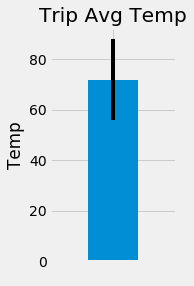

In [75]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,4))
plt.bar(1,results[0][1])
error=results[0][2]-results[0][0]
plt.errorbar(1,results[0][1],error,color='black')
plt.xlim(0,2)
plt.xticks([1],' ')
plt.ylabel('Temp')
plt.title('Trip Avg Temp')
plt.show()

In [136]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
totals = session.query(meas.station,func.sum(meas.prcp)).filter(meas.date>='2016-12-20').\
    filter(meas.date<='2017-01-01').group_by('station').all()
precip_df=pd.DataFrame(totals,columns=['Station','total precipitation'])
precip_df.head()
stat_id = session.query(stat.station,stat.name,stat.latitude,stat.longitude,stat.elevation).all()
stat_df=pd.DataFrame(stat_id,columns=['Station','name','latitude','longitude','elevation'])
stat_df.head()
ps_df = pd.merge(stat_df,precip_df,on='Station')
ps_df.sort_values('total precipitation',ascending=False,inplace=True)
ps_df.head()

,Station,name,latitude,longitude,elevation,total precipitation
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,10.17
5,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.88
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.17
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.54
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.53


In [95]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", meas.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [127]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2020-12-20'
end = '2021-01-01'
# Use the -start and end date to create a range of dates
dat =start
dts=[]
while dat != end:
    cur = dt.datetime.strptime(dat, '%Y-%m-%d')
    dts.append(cur)
    nxt = cur + dt.timedelta(days=1)
    dat = nxt.strftime('%Y-%m-%d')
dts_str=[]
# Stip off the year and save a list of %m-%d strings
for x in dts:
    dts_str.append(x.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date
data ={'date':[],'min':[],'avg':[],'max':[]}
for x in dts_str:
    data['date'].append(x)
    data['min'].append(daily_normals(x)[0][0])
    data['avg'].append(daily_normals(x)[0][1])
    data['max'].append(daily_normals(x)[0][2])

In [124]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame(data)
df.set_index('date',inplace=True)
df.head(12)

,min,avg,max
date,,,
12-20,65.0,72.913043,81.0
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0


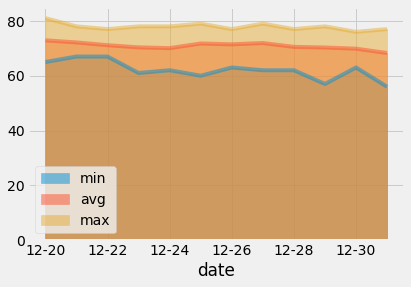

In [126]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.show()